<div style="text-align: center; margin: 50px">

<h1 style="color: white; background-color: grey; text-align: center;">Qubit by Qubit - Semester 2</h1>
<h3>Week 19 lab: Quantum Key Distribution</h3>

</div>

# Overview

1. [Introdução](#intro) <br>
    1.1 [Quantum Key Distribuit](#layout) <br>
    1.2 [Experimento](#specs) <br>
2. [Steps in the QKD protocol](#protocol) <br>
    2.1 [Step 1: Encode Basis (Alice)](#step1) <br>
    2.2 [Step 2: Measurement Basis (Bob)](#step2) <br>
    2.3 [Step 3: Encode (Alice prepara estado)](#step3)  <br>
    2.4 [Step 4: Send (Alice envia estado)](#step4)  <br>
3. [Resumo](#takeaways)  <br>
4. [Leituras Adicionais](#frr)  <br>
5. [Optional content](#optional) <br>
    5.1 [Step 5: Measure (Bob Mede estado que Alice enviou)](#step5) <br>
    5.2 [Step 6: Alice e Bob anunciam a Base que escolheram previamente](#step6) <br>
    5.3 [Step 7: Find symmetric key](#step7) <br>
6. [Exta content - full QKD protocol implementation](#extra) <br>
    6.1 [Challenge problem: Implementing a function for Eve](#challenge) <br>

<a id="intro"></a>
# 1. Introdução

**O que é distribuição de chaves?** A comunicação segura consiste na habilidade de encriptar a mensagem que se deseja enviar de uma maneira que o receptor possa decriptar, mas que seja impossível para algum espião descobrir a mensagem.

Em nosso problema:

- **Alice** envia a mensagem. (transmissor)
- **Bob** recebe a mensagem. (receptor)

A segurança é geralmente é feita com o uso de uma **chave**, a qual é conhecida somente pelo transmissor e receptor da mensagem.

Se a chave pode **ser distribuída com segurança** entre o trasmissor e o receptor, a mensagem criptografada pode ser enviada com segurança por meio de um canal público de comunicação. Sem a chave,  a probabilidade de descriptografar com êxito a mensagem é praticamente zero.


Em geral, **a chave é somente um bitstring** - uma sequência de 0s e 1s, e só somente é conhecida por Alice e Bob, as duas partes que estao se comunicando.

Portanto, o problema da comunicação segura consiste em para garantir a distribuição chave, de maneira segura. Quantum Key Distribution é única porque a segurança contra espiões é garantida pelas próprias leis da mecânica quântica. A garantia de segunraça nos protocolos atuais, consistes na complexidade computacional de certas funções, as quais são utilizadas nas distribuicóes de chaves clássicas.

Vamos implementar um QKD usando qiskit, baseado no protocolo BB84.


<a id="layout"></a>
## 1.1 Quantum Key Distribution

O protocolo BB84 consiste em:

1. `Selecionar Base de Alice (ENCODE BASIS)`: Alice aleatoriamente seleciona a base ( × or + ) para codificar o qubit.
2. `Selecione a Base de Bob (DECODE BASIS`: Bob aleatoriamente seleciona uma base ( × or + ) para medir cada qubit.
3. `ENCODE`: Alice cria um estado quantico, encripta na base selecionada.
4. `SEND`: Alice envia a Bob o estado codificado via um canal quantico de comunicação. 
5. `MEASURE`: Bob mede todos os estados quânticos em sua base de medida pré-selecionada.
6. `ANNOUNCE BASIS`: Alice anuncia, via um canal clássico de comunicação, quais bases ela usou para codificar cada qubit.
7. `FIND SYMMETRIC KEY`: Alice e Bob descartam bits em sua chave em que eles usaram diferentes bases de encoding e docoding. 

Estes 7 passos permitem uma chave ser distribuída entre Alice e Bob de maneira completamente segura. Estando garantido que Alice e Bob podem se comunicar por meio de um canal seguro.


In [47]:
from random import getrandbits
from qiskit import *

<a id="specs"></a>
## 1.2 Experimento

Tamanho da chave (número de bits) 500

Em uma implementação real disso, os fótons físicos serão enviado via fibra óptica para Bob (step 4). Infelizmente, não conseguimos fazer isso no laboratório, então, ao invés disso, podemos representar os fótons sendo transportados colocando-os em um `QUANTUM_CHANNEL` - isso é: uma lista do python.

Similarmente, precisaremos representar o canal clássico de comunicação, o que na vida real poderia ser cabos enviando sinais elétricos, por meio dos quais, Alice irá anunciar sua base (step 6). Podemos representar isso, novamente, usando uma lista em python.

Podemos supor que `CLASSICAL_CHANNEL` é inseguro, e contudo,  está sujeito a ataques de hackers.

In [48]:
KEY_LENGTH = 500
QUANTUM_CHANNEL = []
CLASSICAL_CHANNEL = []

<a id="protocol"></a>
# 2. Steps in the QKD protocol

Implementando QKD Step by Step

<a id="step1"></a>
## 2.1. Step 1: Encode Basis (Alice)

Alice necessita selecionar aleatoriamente um bit para chave e um bit para base. O bit da base será utilizado para codificar o bit da chave.


In [49]:
getrandbits(1)

0

In [50]:
def Alice_encode(length):
    
    #Armazena o estado que a Alice irá codificar
    alice_bitstring = ""
    #Armazena as bases que Alice usará para codificar o estado
    alice_bases = ""
    
    for i in range(length):
        
        # A função getrandbits é utilizada para obter 0 ou 1 aleatoriamente, o argumento 1 na funçao
        # está associado ao limite superior dos número produzido aleatoriamente
        alice_bitstring += (str(getrandbits(1)))
        
        # o resultado 0 significa codificar a chave na base (0,1) e 1 significa codifica na base (+,-)
        alice_bases += (str(getrandbits(1))) #gera 0 ou 1 aleatoriamente
    
    # return the string of bits and the list of bases they should be encoded in
    return alice_bitstring, alice_bases

#### Criar a key da Alice e bitstring da Base da Alice

Vamos criar `alice_key` and `alice_basis`

In [51]:
alice_bitstring, alice_basis = Alice_encode(KEY_LENGTH)

# Preview the first 10 elements of each:
print("alice_key: ", alice_bitstring[:100])
print("alice_bases: ", alice_basis[:100])

alice_key:  1000010101110101101111000110111011101110001110001000111011000111111110111011000101110100011111100110
alice_bases:  1111001011001010010000101110000100111111111010101011110001000111100000000111111111010001110000010011


<a id="step2"></a>
## 2.2. Step 2: Measurement Basis (Bob)

Bob necessita selecionar aleatoriamente a base a qual irá medir cada qubit.


In [52]:
def Bob_meas(length):
    bob_basis = ""
    
    for i in range(length):
        bob_basis += (str(getrandbits(1)))
        
    return bob_basis

#### Criar  Measurement Basis selecionado por Bob

Vamos criar `bob_basis` list


In [53]:
bob_basis = Bob_meas(KEY_LENGTH)

# Preview the first 10 elements of each:
print("selected_measurements: ", bob_basis[:100])

selected_measurements:  1011101111100011010100100100010001110001110110011110100001011110100100000100101110010011010110100111


<a id="step3"></a>
## 2.3. Step 3: Encode (Alice prepara estado) 

Alice agora usa sua lista de random bits para gerar um monte de estados quânticos:

Cada bit key e bit basis será utilizado para criar um `QuantumCircuit` específico.

A tabela abaixo sumariza o estado do qubit que a Alice envia, baseado na base correspendente. Podemos pensar que Alice tem em posse dela dois qubits de informação, o primeiro qubit decide o estado a ser enviado, e o segundo qubit, decido a base em que ela vai medir o estado. $\vert 00\rangle$, $\vert 01\rangle$, $\vert 10\rangle$, $\vert 11 \rangle$.

| Bit in Alice's `alice_key` | Corresponding bit in `alice_basis` | Encoding basis | Qubit state sent |
|:----------------:|:--------------------------:|:--------------------------:|:---------------:|
| 0 | 0 | $$|0\rangle,|1\rangle$$ |$$|0\rangle$$ |
| 0 | 1 | $$|+\rangle,|-\rangle$$ |$$|+\rangle$$ |
| 1 | 0 | $$|0\rangle,|1\rangle$$ |$$|1\rangle$$ |
| 1 | 1 | $$|+\rangle,|-\rangle$$ |$$|-\rangle$$ |

In [54]:
def encode(alice_bitstring, alice_basis):
    encoded_qubits = []
    
    for i in range(len(alice_bitstring)):
        #Criando Circuito Quântico
        qc = QuantumCircuit(1,1)

        if alice_basis[i] == "0":
            # Se 0 a base escolhida é |0>, |1> (z basis)
            if alice_bitstring[i] == "0":
                # Se 0, o estado enviado será |0>
                # Como o circuito quântico, por default é inicialiado em|0> não precisamos fazer nada
                pass
                
            elif alice_bitstring[i] == "1":
                # Se 1, precisamos gerar o estado |1>
                # Para isso aplicamos x no qubit |1>
                qc.x(0)

        elif alice_basis[i] == "1":
            # 1 Means we are encoding in the x basis
            if alice_bitstring[i] == "0":
                # We apply an H gate to generate |+>
                qc.h(0)
            elif alice_bitstring[i] == "1":
                # We apply an X and an H gate to generate |->
                qc.x(0)
                qc.h(0)

        # add this quantum circuit to the list of encoded_qubits
        encoded_qubits.append(qc)
    return encoded_qubits

print(f'{alice_bitstring[0]}, {alice_basis[0]}')
len(encode(alice_bitstring, alice_basis))
encode(alice_bitstring, alice_basis)[:4]

1, 1


### Create Alice's encoded_qubits

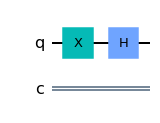

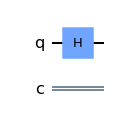

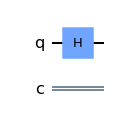

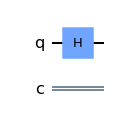

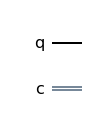

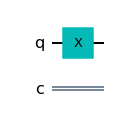

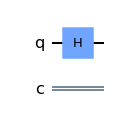

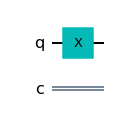

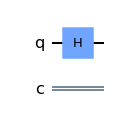

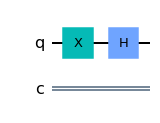

In [55]:
#Criando um circuito para cada par alice_key, alice_basis
encoded_qubits = encode(alice_bitstring, alice_basis)
for qc in encoded_qubits[:10]:
    display(qc.draw('mpl'))

<a id="step4"></a>
## 2.4. Step 4: Send (Alice Envia)

Alice envia os qubits codificados a Bob utilizando um `QUANTUM_CHANNEL`. 

No problema real, Alice envia seus qubits via fibra óptica (por exemplo), que poderia ser o canal quântico.
Aqui, nós somente copiamos o qubit codificado na variável `QUANTUM_CHANNEL`.

In [56]:
# Alice Sends Bob her encoded qubits over the quantum_channel
QUANTUM_CHANNEL = encoded_qubits

<a id="takeaways"></a>
# 3. Resumo

1. Distribuição de Chaves é um passo essencial na segurança da comunicação - isso assegura que Alice e Bobo podem codificar e decodificar a mensagem, mas um hacker não pode.

2. Quantum Key Distribution funciona basicamente com três passos:
    * Alice gera uma sequência de qubits e envia para Bob.
    * Bob mede os qubits recebidos. 
    * Alice and Bob comparam as bases escolhidas e ficam com bits cuja a escolha das bases coicidem.


<a id="frr"></a>
# 4. Leituras Adicionais

1. [Qiskit textbook page on QKD, including QKD with eavesdropping](https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html)
2. [Prospects for large scale QKD](https://arxiv.org/ftp/arxiv/papers/1809/1809.02291.pdf)
3. [Free online quantum learning opportunities](https://quantumapalooza.com/)
4. [Videos on basic QIS concepts](https://www.quantumworlddetangled.com/)
5. [Statistics on QIS technology](https://qisdata.com/)

<a id="optional"></a>
# 5. QKD Avançado - usando qiskit

<a id="step5"></a>
## 5.1. Step 5: Measure (Bob)

Bob mede os qubits em uma base aleatória, escolhida na parte 2.

In [57]:
def measure(bob_bases, encoded_qubits, backend):
    # Realiza a medida o estado que Alice Enviou
    # Seleciona a base de medida (aleatoriamente): 
    # encoded_qubits: lista de circuitos que Alice enviou
    # backend: IBMQ backend, either simulation or hardware
    
    bob_bitstring = ''
    
    for i in range(len(encoded_qubits)):
        qc = encoded_qubits[i]
        
        if bob_bases[i] == "0":
            # 0 means we want to measure in Z basis
            qc.measure(0,0)

        elif bob_bases[i] == "1":
            # 1 means we want to measure in X basis
            qc.h(0)
            qc.measure(0,0)
        
        # Now that the measurements have been added to the circuit, let's run them.
        job = execute(qc, backend=backend, shots = 1) # increase shots if running on hardware
        results = job.result()
        counts = results.get_counts()
        measured_bit = max(counts, key=counts.get)

        # Append measured bit to Bob's measured bitstring
        bob_bitstring += measured_bit 
        
    return bob_bitstring

### Para medir os qubits que Bob recebeu de Alice, usamos `qasm_simulator`

We will use a simulated backend here but feel free to swap this out later in the extra material

In [58]:
sim_backend = Aer.get_backend('qasm_simulator')

bob_bitstring = measure(bob_basis, QUANTUM_CHANNEL, sim_backend)

bob_bitstring

'10001101010101011010110011101011111001000001101110011110110101111110101110010001011101101111010100100000011001100011100001110100100011011101001101100001001000110011111111011001111001000011101100100100100001000010000110110100010100110011111100011100010000111000101111100101000000011100011110111110011000101111000101101011110010110011111001000011101110011011100010101101110000010000101000110101000000110111001101000100011111001000011100001001011011010011000101111010101011101000011011110010101100011101'

<a id="step6"></a>
## 5.2. Step 6: Announce Basis

Alice announces which basis she used to encode each qubit via the `CLASSICAL_CHANNEL`

In [59]:
# Alice sends the list of bases used to create her encoded qubits to bob over the classical channel
CLASSICAL_CHANNEL = alice_basis
alice_basis

'11110010110010100100001011100001001111111110101010111100010001111000000001111111110100011100000100111100011011011111111010101001100001010000010000110010100111100010011110000111111111000011011000011010100001101001110110101101110011001001100100011101110100010011010010011111110111101110100110110001100000110001100010111111101010100100001101000010011110101001100110101111100100110111001100100101011110100110111111110011101110000010011001100110110101010101111011001001101101011010001100011000001111000100'

<a id="step7"></a>
## 5.3. Step 7: Achar Chave Simétrica

Agora que Alice anunciou qual base ela usou para encriptar sua chave, Bob pode verificar na sua lista de escolhas quantas vezes eles escolheram a base igual. 

`As posições onde eles usaram a mesma base são mantidas, e aquelas que as bases foram diferentes, deverão ser descartadas`


In [60]:
def bob_compare_bases(alices_basis, bobs_basis):
    indices = []
    
    for i in range(len(alices_basis)):
        if alices_basis[i] == bobs_basis[i]:
            indices.append(i)
    return indices

#### Agora que Bob conhece as bases escolhidas por Alice para codificar os qubits, ele pode comparar quais bases ele acertou e enviar para Alice as `posições` que ele acertou (na ordem de envio dos qubits).

In [61]:
agreeing_basis = bob_compare_bases(CLASSICAL_CHANNEL, bob_basis)
agreeing_basis

[0,
 2,
 3,
 5,
 6,
 8,
 9,
 11,
 13,
 14,
 16,
 17,
 18,
 20,
 21,
 22,
 23,
 25,
 27,
 28,
 30,
 32,
 34,
 35,
 39,
 40,
 41,
 44,
 45,
 48,
 50,
 52,
 54,
 55,
 56,
 57,
 58,
 61,
 62,
 64,
 65,
 66,
 68,
 69,
 70,
 71,
 72,
 73,
 76,
 78,
 79,
 80,
 82,
 83,
 84,
 85,
 87,
 89,
 90,
 93,
 96,
 98,
 99,
 100,
 101,
 104,
 105,
 108,
 110,
 116,
 117,
 118,
 121,
 122,
 124,
 127,
 128,
 130,
 132,
 134,
 135,
 137,
 138,
 139,
 140,
 142,
 144,
 145,
 146,
 149,
 150,
 154,
 156,
 157,
 163,
 164,
 168,
 169,
 170,
 172,
 173,
 177,
 178,
 179,
 181,
 187,
 188,
 189,
 191,
 192,
 198,
 201,
 202,
 205,
 207,
 208,
 209,
 212,
 213,
 216,
 219,
 220,
 224,
 226,
 227,
 229,
 230,
 231,
 232,
 233,
 238,
 239,
 241,
 245,
 246,
 248,
 251,
 252,
 253,
 257,
 258,
 260,
 261,
 262,
 266,
 270,
 271,
 272,
 279,
 283,
 285,
 286,
 293,
 294,
 295,
 296,
 299,
 303,
 304,
 307,
 311,
 317,
 318,
 319,
 321,
 322,
 325,
 326,
 327,
 328,
 335,
 340,
 341,
 344,
 345,
 346,
 349,
 350,
 3

In [62]:
# Bob envia a lista de posições que deram match, via um canal clássico
CLASSICAL_CHANNEL = agreeing_basis

#### Bob e Alice sabem todas as posições em que eles usaram a mesma base. Eles então `DESCARTAM` todo bit que em que eles usaram bases diferentes. Com isso eles terão uma chave compartilhada e poderão utilizar essa chave para se comunicarem de maneira segura.

In [46]:
def construct_key_from_indices(bitstring, indices):
    key = ''
    for idx in indices:
        # For the indices where bases match, the bitstring bit is added to the key
        key = key + bitstring[idx] 
    return key

In [63]:

alice_key = construct_key_from_indices(alice_bitstring, CLASSICAL_CHANNEL)
bob_key = construct_key_from_indices(bob_bitstring, agreeing_basis)

# Preview the first 100 elements of each Key:

print('----------------------------------------------------------------------------------------------')
print(f'Dos 500 bits iniciais, apenas {len(alice_key)} foram aproveitados para a chave compartilhada.')
print('----------------------------------------------------------------------------------------------')


print("alice_key: ", alice_key[:100])
print("bob_key: ", bob_key[:100])
print("Alice's key is equal to Bob's key: ", alice_key == bob_key)

----------------------------------------------------------------------------------------------
Dos 500 bits iniciais, apenas 254 foram aproveitados para a chave compartilhada.
----------------------------------------------------------------------------------------------
alice_key:  1001001110101110010111100001010110110111111011100010110101110100001011001100101011010101100100111101
bob_key:  1001001110101110010111100001010110110111111011100010110101110100001011001100101011010101100100111101
Alice's key is equal to Bob's key:  True
